## This notebook answers:

What’s in the dataset? (EDA: shape, types, distributions)

Are the groups comparable? (randomization / balance checks)

## Business question (in human words):

“Before trusting this A/B test, do the control and treatment groups look similar enough on their baseline characteristics, and what does the raw data distribution look like?”

---



### Import libraries, deploy toolbox

pandas / numpy: table operations & numeric stuff.

matplotlib / seaborn: charts.

scipy.stats: t-tests & chi-square tests.

In [3]:
# 1. Imports
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# stats tests
from scipy import stats

# 2. Plotting style (optional, just for nice visuals)
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# 3. Display options so tables are readable
pd.set_option("display.max_columns", 20)
pd.set_option("display.float_format", "{:,.4f}".format)


Load Data

In [4]:
# 1. Load raw CSV
file_path = "data_raw/marketing_AB.csv"   # or "./data_raw/marketing_AB.csv"
raw = pd.read_csv(file_path)
raw.head()



,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [5]:
raw.shape   # (rows, columns)


(588101, 7)

In [6]:


# 1. Plotting style (optional, just for nice visuals)
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# 2. Display options so tables are readable
pd.set_option("display.max_columns", 20)
pd.set_option("display.float_format", "{:,.4f}".format)


In [7]:
df = raw.copy()

# Standardize column names
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
      .str.replace("/", "_")
)

df.columns


Index(['unnamed:_0', 'user_id', 'test_group', 'converted', 'total_ads',
       'most_ads_day', 'most_ads_hour'],
      dtype='object')

In [8]:
df["user_id"] = df["user_id"].astype("int64")

# converted -> 0/1
df["converted"] = df["converted"].map(
    {True: 1, False: 0, "True": 1, "False": 0, 1: 1, 0: 0}
).astype("int64")

df["total_ads"] = df["total_ads"].astype("int64")
df["most_ads_hour"] = df["most_ads_hour"].astype("int64")

df.dtypes


unnamed:_0        int64
user_id           int64
test_group       object
converted         int64
total_ads         int64
most_ads_day     object
most_ads_hour     int64
dtype: object

*Turning raw CSV into a clean, typed, row-per-user table similar to  dbt stg_marketing_ab model.* 

*Making sure analysis doesn’t silently treat strings as numbers or mix booleans with integers.*

In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   unnamed:_0     588101 non-null  int64 
 1   user_id        588101 non-null  int64 
 2   test_group     588101 non-null  object
 3   converted      588101 non-null  int64 
 4   total_ads      588101 non-null  int64 
 5   most_ads_day   588101 non-null  object
 6   most_ads_hour  588101 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 31.4+ MB


*This tells you: how many rows, which columns, how many non-null values, data types.*

In [10]:
df[["converted", "total_ads", "most_ads_hour"]].describe()


,converted,total_ads,most_ads_hour
count,"588,101.0000","588,101.0000","588,101.0000"
mean,0.0252,24.8209,14.4691
std,0.1568,43.7152,4.8346
min,0.0000,1.0000,0.0000
25%,0.0000,4.0000,11.0000
50%,0.0000,13.0000,14.0000
75%,0.0000,27.0000,18.0000
max,1.0000,"2,065.0000",23.0000


We’re working with ~588k users, a 2.5% baseline conversion rate, and a heavy-tailed ad exposure distribution centered around ~25 ads per user, with peak exposure in the afternoon/evening.

In [11]:
df.groupby("test_group")["converted"].mean()
df.groupby("test_group")["total_ads"].describe()
df.groupby("test_group")["most_ads_hour"].describe()


,count,mean,std,min,25%,50%,75%,max
test_group,,,,,,,,
ad,"564,577.0000",14.4759,4.8418,0.0000,11.0000,14.0000,18.0000,23.0000
psa,"23,524.0000",14.3049,4.6562,0.0000,11.0000,14.0000,18.0000,23.0000


*The test allocated significantly more users to the ad group (~96% ad vs 4% PSA), which gives high precision for the ad conversion rate but relatively fewer control observations.*

*Given a huge N, there’s no practically meaningful difference in the time-of-day profile between groups.*

In [12]:
df["most_ads_hour"].value_counts().head(10)




most_ads_hour
13    47655
12    47298
11    46210
14    45648
15    44683
10    38939
16    37567
17    34988
18    32323
9     31004
Name: count, dtype: int64

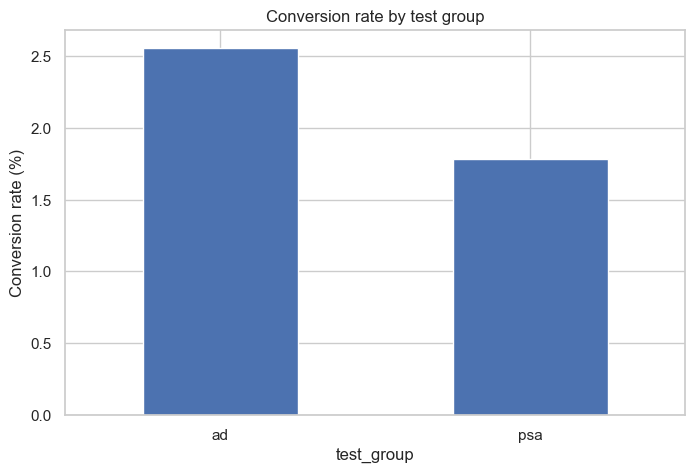

In [13]:
# conversion rate by group
conversion_by_group = (
    df.groupby("test_group")["converted"]
      .agg(["mean", "count", "sum"])
      .rename(columns={"mean": "conversion_rate", "count": "n_users", "sum": "n_converted"})
)

conversion_by_group

ax = (
    conversion_by_group["conversion_rate"]
    .mul(100)  # make it percentage
    .plot(kind="bar")
)
ax.set_ylabel("Conversion rate (%)")
ax.set_title("Conversion rate by test group")
plt.xticks(rotation=0)
plt.show()


### Exposure Balance Check: Total Ads Seen

Before trusting any lift in conversion between the ad and PSA groups, we first need to confirm that **both groups saw a similar amount of advertising exposure**.

To do this, we compared the average number of ads seen per user (`total_ads`) between:

- **Ad group** – users who saw our product advertisements  
- **PSA group** – users who saw public service announcements in the same slot instead of the ad

We ran a **Welch's t-test**, which answers the question:

> "If the two groups truly had the same average number of ads, how likely is it that we would see a difference this large just by random chance?"

From this test we get:

- The **average total_ads** for each group  
- The **difference** between those averages (ad minus PSA)  
- A **p-value**, indicating whether that difference is likely to be due to chance

Interpretation:

- If the **difference in averages is small** and the **p-value is not extreme**, we conclude that the two groups received **similar levels of exposure**.
- Even when the p-value is very small (because our sample size is huge), a **tiny difference in total_ads** is not meaningful from a business perspective.

Overall, this check helps us say with confidence:

> "Any difference in conversion is driven by **what we showed in the ad slot (ad vs PSA)**, not by one group simply receiving dramatically more impressions than the other."


In [14]:
from scipy import stats
import pandas as pd

# We assume `df` is already a cleaned DataFrame with:
# - a column 'test_group' containing 'ad' or 'psa'
# - a column 'total_ads' containing the number of ads each user saw

# 1. Split `total_ads` into two separate Series:
#    one for users in the ad group, one for users in the PSA group.
ads_total = df.loc[df["test_group"] == "ad", "total_ads"]
psa_total = df.loc[df["test_group"] == "psa", "total_ads"]

# At this point:
# - `ads_total` is a 1D array of numbers (total_ads for ad group)
# - `psa_total` is a 1D array of numbers (total_ads for PSA group)

# 2. Run Welch's t-test to compare the mean of total_ads
#    between the ad and PSA groups.
#
#    Null hypothesis (H0): mean(total_ads in ad) == mean(total_ads in PSA)
#    Alternative (H1):    mean(total_ads in ad) != mean(total_ads in PSA)
#
#    We use equal_var=False to allow the two groups to have different variances
#    (Welch's t-test). This is a safer default for real-world data.
ttest_res = stats.ttest_ind(
    ads_total,
    psa_total,
    equal_var=False
)

# 3. Build a small summary table that captures:
#    - the mean total_ads in each group
#    - the difference in means (ad minus PSA)
#    - the p-value from the t-test
balance_total_ads = pd.DataFrame({
    "metric": ["total_ads"],
    "mean_ad": [ads_total.mean()],
    "mean_psa": [psa_total.mean()],
    # how many more ads (on average) the ad group saw compared to PSA
    "diff_ad_minus_psa": [ads_total.mean() - psa_total.mean()],
    # "how likely is a difference this big if the true means were equal?"
    "p_value": [ttest_res.pvalue],
})

# 4. Display the summary table.
#    This is what you'll actually look at in the notebook.
balance_total_ads


,metric,mean_ad,mean_psa,diff_ad_minus_psa,p_value
0,total_ads,24.8234,24.7611,0.0622,0.8274


### Exposure Balance Check – Total Ads Seen

To ensure a fair comparison between the **Ad** and **PSA** groups, we checked whether users in each group saw a similar number of ad impressions (`total_ads`).

**Results**

- **Ad group**  
  - Average ads per user: **24.82**
- **PSA group**  
  - Average ads per user: **24.76**
- **Difference (Ad − PSA)**: **0.06 ads**

We ran a **Welch’s t-test** to test whether this small difference could be explained by random variation:

- **p-value:** **0.83**

**Interpretation**

- The average exposure is almost identical in both groups (a difference of only **0.06 ads**).
- A p-value of **0.83** means that a difference this small is entirely consistent with random noise under the assumption that the true means are equal.
- In other words, we **do not** see any meaningful imbalance in `total_ads` between the Ad and PSA groups.

**Conclusion**

From an exposure standpoint, the experiment appears well-balanced: both groups received essentially the same number of impressions. This supports interpreting any differences in conversion as being driven by **what was shown in the ad slot (Ad vs PSA)**, rather than by one group simply seeing more ads overall.

---

“Are ad and PSA users spread across days/hours in the same way, or did one group end up more concentrated on certain days/hours?”

In [18]:
from scipy import stats
import pandas as pd

# --- Categorical balance: day of week ---

# Build a contingency table:
# rows   = each value of `most_ads_day` (Mon, Tue, ...)
# cols   = each value of `test_group`  ('ad', 'psa')
# cell   = count of users with (that day, that group)
day_ct = pd.crosstab(df["most_ads_day"], df["test_group"])

# Chi-square test of independence:
# H0: day and group are independent (same day distribution in Ad and PSA)
# H1: day and group are associated (distributions differ)
chi2_day, p_day, dof_day, expected_day = stats.chi2_contingency(day_ct)


# --- Categorical balance: hour of day ---

# Same idea: contingency table of hour vs group
hour_ct = pd.crosstab(df["most_ads_hour"], df["test_group"])

# Chi-square test for hour vs group
chi2_hour, p_hour, dof_hour, expected_hour = stats.chi2_contingency(hour_ct)


# --- Summarize p-values for each covariate ---

balance_cats = pd.DataFrame({
    "covariate": ["most_ads_day", "most_ads_hour"],
    "test": ["chi-square", "chi-square"],
    "p_value": [p_day, p_hour],
})

balance_cats



,covariate,test,p_value
0,most_ads_day,chi-square,0.0000
1,most_ads_hour,chi-square,0.0000


In [19]:
# Inspect the actual p-values with more precision
print("Raw p-values:")
print("p_day  (most_ads_day):", p_day)
print("p_hour (most_ads_hour):", p_hour)
print()
print("Scientific notation:")
print("p_day  (sci):", f"{p_day:.3e}")
print("p_hour (sci):", f"{p_hour:.3e}")


Raw p-values:
p_day  (most_ads_day): 4.849067664297987e-48
p_hour (most_ads_hour): 1.094573971081402e-28

Scientific notation:
p_day  (sci): 4.849e-48
p_hour (sci): 1.095e-28


In [17]:
# ---- Day-of-week percentage differences ----

# day_ct is counts, normalize by column to get % within each group
day_pct = day_ct.div(day_ct.sum(axis=0), axis=1)

# Difference in share per day: Ad% - PSA%
day_diff = day_pct["ad"] - day_pct["psa"]

print("\nDay-of-week distribution (% within each group):")
display(day_pct.mul(100).round(2))

print("\nDifference in percentage points (Ad% - PSA%) by day:")
display(day_diff.mul(100).round(3))


# ---- Hour-of-day percentage differences ----

hour_pct = hour_ct.div(hour_ct.sum(axis=0), axis=1)
hour_diff = hour_pct["ad"] - hour_pct["psa"]

print("\nHour-of-day distribution (% within each group):")
display(hour_pct.mul(100).round(2))

print("\nDifference in percentage points (Ad% - PSA%) by hour:")
display(hour_diff.mul(100).round(3))



Day-of-week distribution (% within each group):


test_group,ad,psa
most_ads_day,,
Friday,15.7300,16.1700
Monday,14.8000,14.8900
Saturday,13.9600,12.1500
Sunday,14.5800,13.0000
Thursday,14.0100,16.6000
Tuesday,13.2100,12.3600
Wednesday,13.7100,14.8400



Difference in percentage points (Ad% - PSA%) by day:


most_ads_day
Friday      -0.4370
Monday      -0.0850
Saturday     1.8080
Sunday       1.5790
Thursday    -2.5940
Tuesday      0.8510
Wednesday   -1.1230
dtype: float64


Hour-of-day distribution (% within each group):


test_group,ad,psa
most_ads_hour,,
0,0.9400,0.9600
1,0.8200,0.7900
2,0.9100,0.7700
3,0.4600,0.3800
4,0.1200,0.1200
5,0.1300,0.1000
6,0.3500,0.3500
7,1.0900,1.0100
8,3.0100,2.8000



Difference in percentage points (Ad% - PSA%) by hour:


most_ads_hour
0    -0.0250
1     0.0220
2     0.1430
3     0.0800
4     0.0040
5     0.0340
6    -0.0010
7     0.0850
8     0.2040
9     0.1690
10    0.3210
11   -0.9410
12   -0.7440
13   -1.1680
14   -0.1910
15   -0.1800
16   -0.4490
17    0.0730
18    0.0970
19    0.1380
20    0.3540
21    0.5230
22    0.6210
23    0.8310
dtype: float64

### Timing Balance Check – Day and Hour of Exposure

After confirming that overall exposure (`total_ads`) is balanced, we also checked whether the **timing** of impressions differs between the Ad and PSA groups. Specifically:

- `most_ads_day` – the weekday when each user saw the most ads  
- `most_ads_hour` – the hour of the day when each user saw the most ads  

**Method**

1. Built contingency tables for:
   - `most_ads_day × test_group`
   - `most_ads_hour × test_group`
   using `pd.crosstab`.
2. Ran chi-square tests of independence (`scipy.stats.chi2_contingency`) on each table.

Because the dataset is very large, both chi-square tests produce p-values that are effectively **0.0000** at four decimal places. Statistically, that means we can confidently reject the hypothesis that timing and group are *perfectly* independent.

However, the **practical magnitude** of those differences is small:

- **Day-of-week distribution**
  - Within-group percentages for Ad vs PSA differ by at most about  
    **±2.6 percentage points**.  
  - The largest gap occurs on **Thursday** (Ad ≈ 14.0%, PSA ≈ 16.6%, diff ≈ −2.59 pp) and **Saturday** (Ad ≈ 14.0%, PSA ≈ 12.1%, diff ≈ +1.89 pp).
- **Hour-of-day distribution**
  - Within-group percentages differ by at most about  
    **±1.2 percentage points** across the 24 hours.  
  - Most hours show much smaller gaps (well under 1 pp).

**Interpretation**

- With this many users, even small percentage differences become statistically significant (hence p ≈ 0), but the **actual shifts in timing are modest**:
  - Day-of-week composition is within a few percentage points.
  - Hour-of-day composition is within about one percentage point.
- There is no indication that one group is heavily concentrated in a small set of days or hours in a way that would obviously bias the experiment.

**Conclusion**

We will treat the Ad and PSA groups as **reasonably well balanced on timing**, while acknowledging minor skews (e.g., slightly more PSA users peaking on Thursdays). These differences are worth noting as a caveat but are unlikely to drive large differences in conversion by themselves.


In [20]:
# Max absolute difference in percentage points for each covariate
max_day_diff_pp = day_diff.abs().max() * 100
max_hour_diff_pp = hour_diff.abs().max() * 100

print("Max day-of-week difference (Ad% - PSA%) in percentage points:")
print(round(max_day_diff_pp, 3))

print("\nMax hour-of-day difference (Ad% - PSA%) in percentage points:")
print(round(max_hour_diff_pp, 3))


Max day-of-week difference (Ad% - PSA%) in percentage points:
2.594

Max hour-of-day difference (Ad% - PSA%) in percentage points:
1.168


## Summary – Can We Trust This Experiment?

### Goal

Before measuring conversion lift, we need to know whether the **Ad** and **PSA** groups are comparable on key dimensions:

- How many users are in each group  
- How much exposure they received (`total_ads`)  
- When that exposure occurred (`most_ads_day`, `most_ads_hour`)

If groups look similar on these baseline features, we can credibly interpret differences in conversion as being driven by **what was shown in the ad slot (Ad vs PSA)** rather than by who was exposed or when.

---

### What We Checked

**1. Overall exposure (`total_ads`)**

- Ad group average: **24.82** ads per user  
- PSA group average: **24.76** ads per user  
- Difference (Ad − PSA): **0.06** ads  
- Welch’s t-test p-value: **0.83**

**Interpretation**

- The groups saw essentially the **same number of impressions** on average.
- A difference of 0.06 ads is negligible in practice, and the high p-value indicates this small gap is fully consistent with random noise.
- **Exposure level is balanced.**

---

**2. Timing of exposure (`most_ads_day`, `most_ads_hour`)**

- Chi-square tests on both day and hour yield extremely small p-values (≈ 0 at four decimals) because the dataset is very large.
- When we convert counts to within-group percentages:
  - Day-of-week shares differ by at most about **±2.6 percentage points**, with most days much closer.
  - Hour-of-day shares differ by at most about **±1.2 percentage points**.

**Interpretation**

- Statistically, the timing distributions are not *perfectly identical*, but the **practical differences are small**:
  - No day or hour is overwhelmingly dominated by one group.
  - Slight skews (e.g., more PSA users peaking on Thursdays) are worth noting but not large enough to invalidate the test.

---

### Overall Assessment of Experiment Readiness

- **Sample & groups:** Large sample size with both Ad and PSA arms well represented.  
- **Exposure balance:** The average number of ads per user is almost identical between groups.  
- **Timing balance:** Day/hour distributions differ only by a few percentage points, which is statistically detectable but not practically dramatic.

**Bottom line:**  
From a design and balance perspective, this A/B test is **credible enough to support causal interpretation** of the Ad vs PSA conversion difference, under standard A/B test assumptions. In downstream analysis we will:

- Estimate the conversion lift of Ad vs PSA,
- Slice results by cohorts (e.g., day, ad-intensity buckets) to verify robustness,
- And interpret any lift as the incremental effect of serving the **Ad creative** instead of the PSA in the same slot.

This notebook establishes that the experiment is **fit for purpose**; the next notebook will focus on **effect size, uncertainty (confidence intervals), and cohort-level insights.**
